In [1]:
#papermill_description=imports

import json
import os
import geopandas as gpd
from io import StringIO
import rasterio
import matplotlib.pyplot as plt
import numpy as np

from geodata_fetch import settingshandler, harvest

from gis_utils.stac import initialize_stac_client, query_stac_api, process_dem_asset, save_metadata_sidecar, process_dem_asset_and_mask
from gis_utils.dataframe import get_bbox_from_geodf
import rasterio.plot
import logging
import sys
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rasterio.io import MemoryFile
from matplotlib import cm
from matplotlib.colors import Normalize
from rasterio.plot import reshape_as_raster
from rasterio.warp import calculate_default_transform, reproject, Resampling


# Configure logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=get_coords_from_geodataframe

def get_coords_from_geodataframe(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [3]:
#papermill_description=parameters

notebook_key = "localjupyter"
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}
propertyName = "test"
output_type = "overlay"
colormap = "viridis"


In [4]:
#papermill_description=process_variables

# Construct the filenames using propertyName
# name_property-name_attribute.extension


output_tiff_directory = f"/tmp/{notebook_key}"

In [5]:
#papermill_description=processing_file_io

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

In [6]:
#papermill_description=processing_bounding_box

geom = gdf.geometry #for data-harvester clip function

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

# Get polygon coordinates in rasterio-friendly format
coords = get_coords_from_geodataframe(gdf)

gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
gdf_lat = gdf.centroid.y[0]

/tmp/ipykernel_9537/4045677797.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
/tmp/ipykernel_9537/4045677797.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lat = gdf.centroid.y[0]


In [7]:
#papermill_description=processing_make_harvest_json

target_bbox = bbox
add_buffer = False
resample=False

# Resolution of data download in arcseconds (1 arcsec ~ 30m)
target_res = 1
target_proj = "EPSG:3857" #find way to set this once at top of notebook and  have it feed through to everything else

date_start = "2022-10-01" #these aren't needed but are expected in the package - need to fix
date_end = "2022-11-30" #these aren't needed but are expected in the package - need to fix
time_intervals = 0

target_sources = {"SLGA":{
                      "Organic_Carbon": ["0-5cm"]
                  }}

data_mask=True

json_data = {
    "property_name":propertyName,
    "outpath": output_tiff_directory,
    "data_mask": data_mask,
    "target_res": str(target_res),
    "target_crs": target_proj,
    "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
    "date_end": date_end if date_end is not None else "2022-11-30",
    "target_centroid_lat": gdf_lat,
    "target_centroid_lng": gdf_lon,
    "time_intervals": time_intervals,
    "target_sources": target_sources,
    "target_bbox": target_bbox,
    "add_buffer": add_buffer,
    "resample": resample
}

# Converting dictionary to JSON formatted string
data = json.dumps(json_data)
print(data)

# Create a file-like object from JSON string
json_file_like = StringIO(data)

{"property_name": "test", "outpath": "/tmp/localjupyter", "data_mask": true, "target_res": "1", "target_crs": "EPSG:3857", "date_start": "2022-10-01", "date_end": "2022-11-30", "target_centroid_lat": -29.263026061552612, "target_centroid_lng": 116.32813629361138, "time_intervals": 0, "target_sources": {"SLGA": {"Organic_Carbon": ["0-5cm"]}}, "target_bbox": [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107], "add_buffer": false, "resample": false}


In [8]:
#papermill_description=download_slga_data

df = harvest.run(json_file_like, geom)

Found the following 1 sources: ['SLGA']


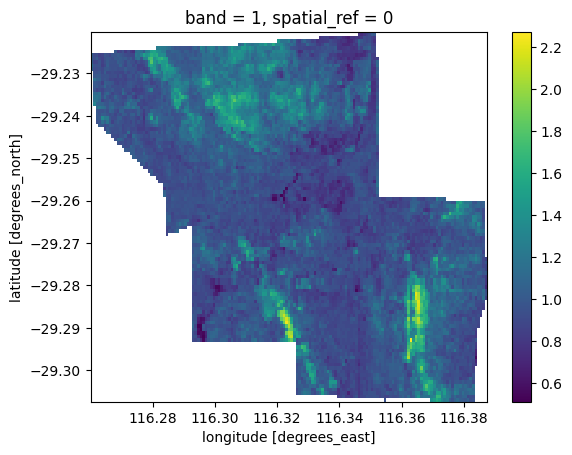

In [9]:
#papermill_description=processing

#plot one of the fetched data layers to check it looks right
df.plot()

"""
TODO: write function that gets zonal statistics for the raster layers e.g. max and min soil organic carbon
"""

"""
TODO: write out metadata needed for staging/production to a sidecar file
"""

# # asset_type signifies the type of asset, e.g. overlay that is stored in the application DB
asset_metadata = { }

In [11]:
#papermill_description=processing_cog

"""
Currently, when the geodata harvester does clipping and masking, it saves the original data and the clipped data in separate sub-directories. So, for now, the processing_cog cell needs to use the sub-directory containing the clipped data. This will be fixed in the future.

Also, because the SLGA notebook may download multiple geotifs, the cog process needs to be run in a loop.
"""

clipped_output_tiff_directory = output_tiff_directory + '/masked-data'

for tiff in os.listdir(clipped_output_tiff_directory):
    if tiff.endswith('.tif'):
        output_tiff_filename = os.path.join(clipped_output_tiff_directory, tiff)
        output_colored_tiff_filename = output_tiff_filename.replace('.tif', '_colored.tif')
        output_cog_filename = output_tiff_filename.replace('.tif', '_cog.public.tif')
        
    with rasterio.open(output_tiff_filename) as mew:
        meta = mew.meta.copy()
        dst_crs = rasterio.crs.CRS.from_epsg(4326)
        transform, width, height = calculate_default_transform(
            mew.crs, dst_crs, mew.width, mew.height, *mew.bounds
        )

        meta.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        tif_data = mew.read(1, masked=True).astype('float32') #setting masked=True here tells rasterio to use masking information if present, but we need to add the mask itself first.
        mew_formatted = tif_data.filled(np.nan)

        cmap = cm.get_cmap('viridis') #can also use 'terrain' cmap to keep this the same as the preview image from above.
        na = mew_formatted[~np.isnan(mew_formatted)]

        min_value = min(na)
        max_value = max(na)

        norm = Normalize(vmin=min_value, vmax=max_value)

        coloured_data = (cmap(norm(mew_formatted))[:, :, :3] * 255).astype(np.uint8)

        meta.update({"count":3})


        with rasterio.open(output_colored_tiff_filename, 'w', **meta) as dst:
            reshape = reshape_as_raster(coloured_data)
            dst.write(reshape)

    try:
        dst_profile = cog_profiles.get('deflate')
        with MemoryFile() as mem_dst:
            cog_translate(
                output_colored_tiff_filename,
                output_cog_filename,
                config=dst_profile,
                in_memory=True,
                dtype="uint8",
                add_mask=False,
                nodata=0,
                dst_kwargs=dst_profile
            )
        
        save_metadata_sidecar(output_cog_filename, asset_metadata)    
    except:
        raise Exception('Unable to convert to cog')


/tmp/ipykernel_9537/1463105702.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis') #can also use 'terrain' cmap to keep this the same as the preview image from above.
Reading input: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_colored.tif

Updating dataset tags...
Writing output to: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_cog.public.tif


Reading input: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_colored_colored.tif

Updating dataset tags...
Writing output to: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_colored_cog.public.tif
Reading input: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_cog.public_colored.tif

Updating dataset tags...
Writing output to: /tmp/localjupyter/masked-data/masked_SLGA_Organic_Carbon_0-5cm_test_cog.public_cog.public.tif
